# Notebook to inspect data and model results for Toloumne

# Step 0 Set up Notebook 

In [1]:
import pandas as pd
import ee
import geopandas as gpd
import numpy as np
import xarray as xr 
import pyproj
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import griddata
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe import get_lidar_data as lidar
from snowML.datapipe.utils import snow_types as st 
from snowML.viz import vis_utils as vu
from snowML.datapipe.utils import data_utils as du 
from snowML.LSTM import LSTM_plot3 as plot3
#from snowML.LSTM import LSTM_evaluate as evaluate
from snowML.LSTM import LSTM_metrics as metrics

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
ee.Authenticate(auth_mode = "notebook")

True

# Step 1 - Get Toloumne Non-Ephemernal 

In [4]:
# Toloumne Hucs 
huc_id = 18040009
huc_lev = '12'
geos_12 = gg.get_geos_with_name(huc_id, huc_lev)
geos_12 = geos_12.set_index("huc_id")

In [5]:
geos_12.shape

(57, 3)

# Step 2 - Filter to Ephemeral 

In [6]:
# Get snow_type
huc_id = 18040009
huc_lev = '12'
df_snow_types, snow_class_counts, df_predom = st.process_all(huc_id, huc_lev)
print(f"Counts: {snow_class_counts}")
df_predom = df_predom[["huc_id", "Predominant_Snow"]]
df_predom = df_predom.set_index("huc_id")
df_predom.head(2)

Counts: {'Ephemeral': 35, 'Maritime': 12, 'Prairie': 5, 'Montane Forest': 4, 'Tundra': 1}


,Predominant_Snow
huc_id,
180400090101,Montane Forest
180400090102,Tundra


In [7]:
# merge snow types into gdf
geos_12_merged = geos_12.merge(df_predom, left_index=True, right_index=True, how="left")
print(geos_12_merged.shape)
geos_12_merged.head()



(57, 4)


,name,huc_name,geometry,Predominant_Snow
huc_id,,,,
180400090101,Lyell Fork,Lyell Fork,"POLYGON ((-119.21739 37.81832, -119.21773 37.8...",Montane Forest
180400090102,Dana Fork,Dana Fork,"POLYGON ((-119.19928 37.88483, -119.19931 37.8...",Tundra
180400090103,Conness Creek,Conness Creek,"POLYGON ((-119.31781 37.9878, -119.31822 37.98...",Montane Forest
180400090104,Regulation Creek,Regulation Creek,"POLYGON ((-119.46359 37.96083, -119.46321 37.9...",Prairie
180400090105,Return Creek,Return Creek,"POLYGON ((-119.34908 38.08655, -119.34926 38.0...",Montane Forest


In [8]:
df_slim = geos_12_merged[geos_12_merged["Predominant_Snow"] != "Ephemeral"]
print(df_slim.shape)

(22, 4)


In [9]:
huc_id_list = list(df_slim.index.values)
huc_id_list

['180400090101',
 '180400090102',
 '180400090103',
 '180400090104',
 '180400090105',
 '180400090106',
 '180400090107',
 '180400090201',
 '180400090202',
 '180400090301',
 '180400090302',
 '180400090303',
 '180400090401',
 '180400090402',
 '180400090403',
 '180400090404',
 '180400090501',
 '180400090502',
 '180400090503',
 '180400090504',
 '180400090601',
 '180400090801']

# Step 3 Get UA_SWE + Predictions (Local Training)

Assumes you have already run the predicitions and downloaded them using script "eval_muli

In [10]:
def filter_by_date (df, filter_date):
    df_filtered = df[df.index >= filter_date]
    return df_filtered

In [11]:
def get_UA_swe(huc_id, filter_date):
    f_df = f"../../mlflow_data/predictions/predictions_{huc_id}.csv"
    df_UA = pd.read_csv(f_df)
    df_UA['day'] = pd.to_datetime(df_UA['day'])
    df_UA = df_UA.set_index("day")
    df_UA = filter_by_date(df_UA, filter_date)
    f_metrics = f"../../mlflow_data/predictions/metric_dict_{huc_id}.json"
    with open(f_metrics, 'r') as f:
        metrics_dict = json.load(f)
    return df_UA, metrics_dict

In [12]:
# example:
huc_id = huc_id_list[0] 
print(huc_id)
filter_date = "2013-01-01"
df_UA, metrics_dict = get_UA_swe(huc_id, filter_date)
print(df_UA.shape)
df_UA.head(2)

180400090101
(3559, 2)


,mean_swe,mean_swe_predict
day,,
2013-01-01,0.3704,0.380700
2013-01-02,0.3686,0.383929


In [13]:
print (metrics_dict)

{'test_mse': 0.017309892922639847, 'test_kge': 0.6478671468466728, 'test_r2': 0.8567527532577515, 'test_mae': 0.06758894771337509}


# Step 4 - Get Lidar Data

In [14]:
#files = lidar.get_files()

In [15]:
# load all lidar data & inspect
f = "lidar_all.zarr"
b = "snowml-bronze" 
zarr_store_url = f's3://{b}/{f}'
ds_lidar = xr.open_zarr(zarr_store_url, consolidated=True, storage_options={'anon': False})

/home/suetboyd/miniconda3/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [16]:
# look at a subset by huc 
clipped = lidar.subset_by_huc(ds_lidar, huc_id)
lidar.count_na(clipped)
clipped

for day All:
Number of NaN values: 21449300
Percent of NaN values: 94.06%


<xarray.Dataset> Size: 182MB
Dimensions:      (y: 743, day: 39, x: 787)
Coordinates:
    band         int64 8B ...
  * y            (y) float64 6kB 37.74 37.74 37.74 37.74 ... 37.87 37.87 37.87
  * day          (day) object 312B '20130403' '20130429' ... '20180528'
  * x            (x) float64 6kB -119.3 -119.3 -119.3 ... -119.2 -119.2 -119.2
    spatial_ref  int64 8B 0
Data variables:
    SWE          (day, y, x) float64 182MB dask.array<chunksize=(5, 254, 401), meta=np.ndarray>

In [17]:
#lidar.plot_valid_pixels(clipped)

In [18]:
df_Lidar = lidar.calc_mean(clipped)
df_Lidar.head(2)

,mean_swe_lidar
day,
2013-04-03,0.410668
2013-04-29,0.268418


In [19]:
# merge the lidar data into the df_UA df as column "mean_swe_lidar"
df_joined = df_UA.join(df_Lidar, how='outer')

In [20]:
# create a small df that only has rows w/lidar data 
df_joined_small = df_joined[df_joined["mean_swe_lidar"].notna()]
df_joined_small.head(2)

,mean_swe,mean_swe_predict,mean_swe_lidar
day,,,
2013-04-03,0.5920,0.309652,0.410668
2013-04-29,0.3772,0.260307,0.268418


In [21]:
metrics.calc_metrics(df_joined_small["mean_swe"], df_joined_small["mean_swe_lidar"], metric_type = "physics_v_lidar")

{'physics_v_lidar_mse': 0.009027135740172217,
 'physics_v_lidar_kge': 0.7489536628105902,
 'physics_v_lidar_r2': 0.8830354631886123,
 'physics_v_lidar_mae': 0.07888366279793321}

In [22]:
metrics.calc_metrics(df_joined_small["mean_swe_predict"], df_joined_small["mean_swe_lidar"], metric_type = "LSTM_predict_v_lidar")

{'LSTM_predict_v_lidar_mse': 0.0035146767119026688,
 'LSTM_predict_v_lidar_kge': 0.9439600988013144,
 'LSTM_predict_v_lidar_r2': 0.9226398276508332,
 'LSTM_predict_v_lidar_mae': 0.04679742445821024}

# Step 4 Get SWE Data UCLA 

In [23]:
def get_UCLA_swe(huc_id, filter_date):
    f = f"mean_swe_ucla_2_in_{huc_id}.csv" 
    #f = f"mean_swe_in_{huc_id}_UCLA.csv"
    b = "snowml-gold"
    df_UCLA = du.s3_to_df(f, b)
    df_UCLA['day'] = pd.to_datetime(df_UCLA['day'])
    df_UCLA = df_UCLA.set_index("day")
    df_UCLA = filter_by_date(df_UCLA, filter_date)
    return df_UCLA

In [24]:
df_UCLA = get_UCLA_swe(huc_id, filter_date)
df_UCLA.head(2)

,SWE_Post
day,
2013-01-01,0.505659
2013-01-02,0.505624


# Step 5 - PLot

In [25]:
# custom assemble plot function; but use plot3 module plot3b function 
def assemble_plot_dict(y_vals, color, label, n_offset=0, sparse = False):
    plot_dict = {}
    plot_dict["y_axis_vals"] = np.concatenate([np.full(n_offset, np.nan), y_vals])
    plot_dict["color"] = color
    plot_dict["label"] = label
    plot_dict["sparse"] = sparse
    return plot_dict

In [26]:
def compile_plot_data(df_UA, metrics_dict, df_joined, df_joined_small, df_UCLA):
    x_axis_vals = df_UA.index.to_list()
    UA_dict = assemble_plot_dict(df_UA["mean_swe"], "blue", "UA_data (Physics Based Model Prediction")
    UA_dict_pred = assemble_plot_dict(df_UA["mean_swe_predict"], "green", "Model Predictions - UA Data multi-huc_trained model")
    Lidar_dict = assemble_plot_dict(df_joined["mean_swe_lidar"], "red", "Lidar data", sparse = True)
    
    # Pad the UCLA data with zeros so the plot fits 
    num_zeros = len(x_axis_vals) - len(df_UCLA["SWE_Post"])
    extended_series = pd.concat([
        df_UCLA["SWE_Post"],
        pd.Series([0] * num_zeros, index=x_axis_vals[len(df_UCLA["SWE_Post"]):])
    ])
    UCLA_dict = assemble_plot_dict(extended_series, "black", "UCLA Model Data")

    met_dict2 = metrics.calc_metrics(df_joined_small["mean_swe"], df_joined_small["mean_swe_lidar"], metric_type = "physics_v_lidar")
    met_dict_3 = metrics.calc_metrics(df_joined_small["mean_swe_predict"], df_joined_small["mean_swe_lidar"], metric_type = "LSTM_predict_v_lidar") 
    #combined_met_dict = {**metrics_dict, **met_dict2, **met_dict_3}
    combined_met_dict = {**metrics_dict, **met_dict_3}
    y_dict_list = [UA_dict, UA_dict_pred, Lidar_dict, UCLA_dict]

    return x_axis_vals, y_dict_list, combined_met_dict

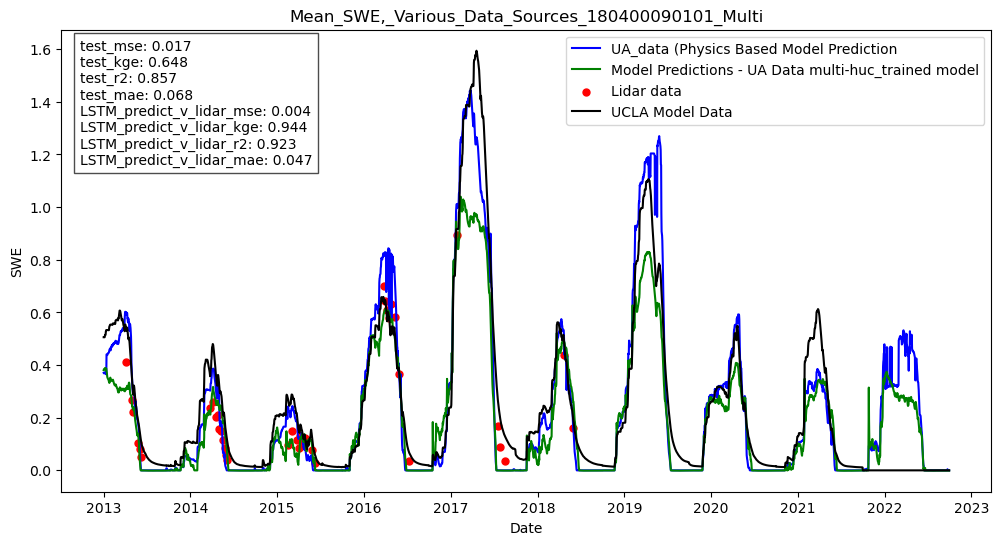

In [27]:
ttl = f"Mean_SWE,_Various_Data_Sources_{huc_id}_Multi"
x_axis_vals, y_dict_list, met_dict = compile_plot_data(df_UA, metrics_dict, df_joined, df_joined_small, df_UCLA)
plt = plot3.plot3b(x_axis_vals, y_dict_list, ttl, metrics_dict = met_dict)
plt.show()
plt.close()

# Step 6 - Putting it all together

In [31]:
def new_row(huc_id, combined_met_dict):
    # Build the row data with all values
    cols  = ["huc_id"] + list(combined_met_dict.keys())
    values = [huc_id] +  [combined_met_dict.get(col) for col in cols[1:]]
    new_row_df = pd.DataFrame([values], columns=cols).set_index(cols[0])
    return new_row_df

In [32]:
def compare_all(huc_list, filter_date = "2013-01-01"): 
    # initialize results_df
    metrics_df = pd.DataFrame()
    
    for huc_id in huc_list: 
        df_UA, metrics_dict = get_UA_swe(huc_id, filter_date)
        clipped = lidar.subset_by_huc(ds_lidar, huc_id)
        df_Lidar = lidar.calc_mean(clipped)
        df_joined = df_UA.join(df_Lidar, how='outer')
        df_joined_small = df_joined[df_joined["mean_swe_lidar"].notna()]
        ttl = f"Mean_SWE,_Various_Data_Sources_{huc_id}"
        x_axis_vals, y_dict_list, met_dict = compile_plot_data(df_UA, metrics_dict, df_joined, df_joined_small, df_UCLA)
        row = new_row(huc_id, met_dict)
        metrics_df = pd.concat([metrics_df, row])
        plt = plot3.plot3b(x_axis_vals, y_dict_list, ttl, metrics_dict = met_dict)
        f_out = f"charts/Local_Training_Results/UA_Results_and_Lidar_for_huc_{huc_id}_w_UCLA_dat"
        #plt.show()
        plt.savefig(f_out + ".png", dpi=300, bbox_inches='tight')
        plt.close()
    
    return metrics_df
        
        

In [33]:
metrics_df = compare_all(huc_id_list)

Error: Zero variance detected in y_true or y_pred
Error: Zero variance detected in y_true or y_pred
Error: Zero variance detected in y_true or y_pred
Error: Zero variance detected in y_true or y_pred
Error: Zero variance detected in y_true or y_pred
Error: Zero variance detected in y_true or y_pred


In [34]:
metrics_df.head()

,test_mse,test_kge,test_r2,test_mae,LSTM_predict_v_lidar_mse,LSTM_predict_v_lidar_kge,LSTM_predict_v_lidar_r2,LSTM_predict_v_lidar_mae
huc_id,,,,,,,,
180400090101,0.017310,0.647867,0.856753,0.067589,0.003515,0.943960,0.922640,0.046797
180400090102,0.014464,0.642524,0.845825,0.060099,0.004699,0.882461,0.868542,0.059593
180400090103,0.010381,0.742076,0.897141,0.055942,0.012748,0.615370,0.723963,0.089346
180400090104,0.011160,0.933442,0.935243,0.059042,0.050399,0.532911,0.405266,0.141874
180400090105,0.008710,0.936770,0.931111,0.053230,0.013424,0.836616,0.708298,0.091810


In [35]:
metrics_df.describe()

,test_mse,test_kge,test_r2,test_mae,LSTM_predict_v_lidar_mse,LSTM_predict_v_lidar_kge,LSTM_predict_v_lidar_r2,LSTM_predict_v_lidar_mae
count,22.000000,22.000000,22.000000,22.000000,22.000000,19.000000,22.000000,22.000000
mean,0.011483,0.837737,0.903119,0.051228,0.016410,0.628948,0.457574,0.080539
std,0.010970,0.103876,0.032587,0.024529,0.015656,0.260801,0.497559,0.047547
min,0.000945,0.640157,0.837301,0.015081,0.000298,-0.198288,-1.240135,0.006845
25%,0.003797,0.764819,0.886774,0.031158,0.004861,0.581690,0.426784,0.048134
50%,0.008852,0.876967,0.910372,0.052398,0.011440,0.662911,0.579128,0.076930
75%,0.013970,0.907316,0.930393,0.060962,0.018695,0.768902,0.752331,0.103889
max,0.047105,0.957009,0.939844,0.113912,0.050399,0.943960,0.922640,0.170368


# Step Last - Graphs of Results Accross Hucs 

In [36]:
# add snowtytpe data back to huc
df_snow = geos_12_noE[["Predominant_Snow", "Snow_Type_Color"]]
metrics_df = metrics_df.merge(df_snow, left_index=True, right_index=True, how="left")
metrics_df.head(2)

,test_mse,test_kge,test_r2,test_mae,LSTM_predict_v_lidar_mse,LSTM_predict_v_lidar_kge,LSTM_predict_v_lidar_r2,LSTM_predict_v_lidar_mae,Predominant_Snow,Snow_Type_Color
huc_id,,,,,,,,,,
180400090101,0.017310,0.647867,0.856753,0.067589,0.003515,0.943960,0.922640,0.046797,Montane Forest,darkgreen
180400090102,0.014464,0.642524,0.845825,0.060099,0.004699,0.882461,0.868542,0.059593,Tundra,gray


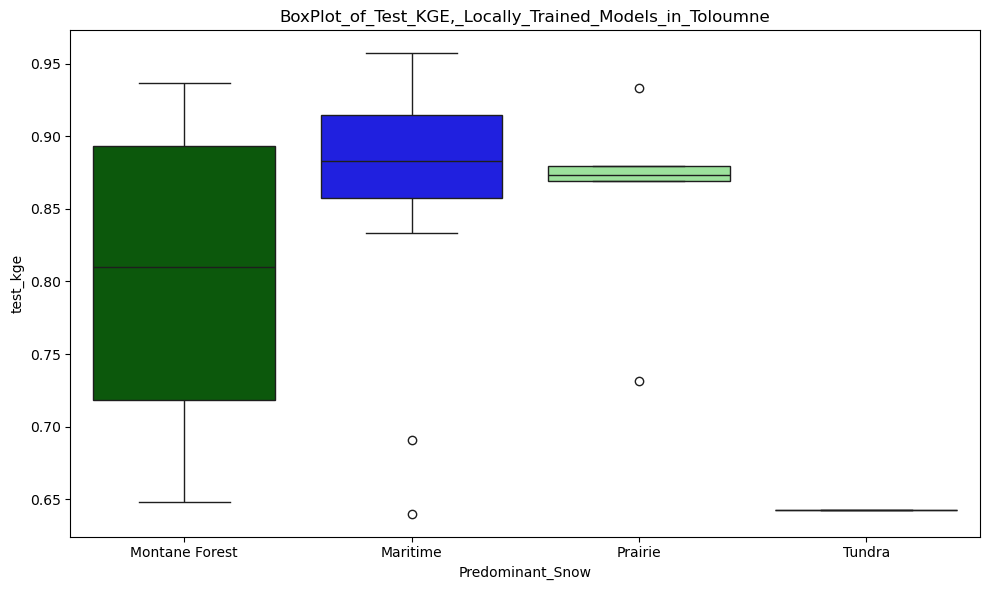

,count,median,mean,std
Predominant_Snow,,,,
Maritime,12,0.882930,0.858000,0.096470
Montane Forest,4,0.810183,0.801251,0.130803
Prairie,5,0.873445,0.857335,0.075191
Tundra,1,0.642524,0.642524,NaN


In [37]:
# boxplot of KGE by SnowTypes 
from snowML.viz import vis_utils as vu
parameter = "test_kge"
title = "BoxPlot_of_Test_KGE,_Locally_Trained_Models_in_Toloumne"
groupby_column = "Predominant_Snow"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Prairie", "Tundra"])
vu.plot_boxplot_by_group(metrics_df, parameter, title, groupby_column, color_map=color_map, category_order=None, trunc=False, save_local=True)


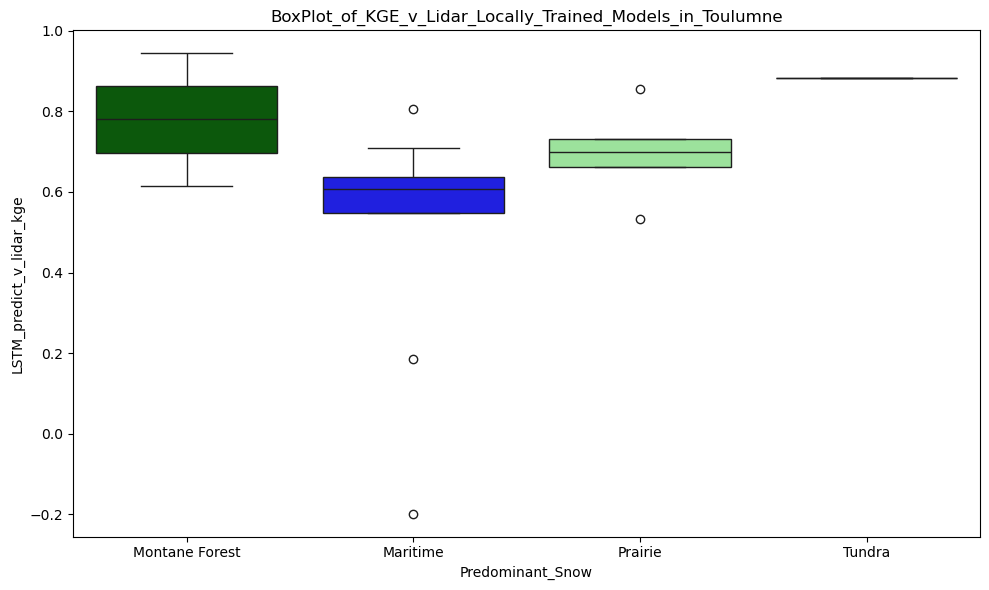

,count,median,mean,std
Predominant_Snow,,,,
Maritime,9,0.608187,0.496336,0.310947
Montane Forest,4,0.780949,0.780307,0.141639
Prairie,5,0.698103,0.695857,0.116253
Tundra,1,0.882461,0.882461,NaN


In [38]:
# boxplot of KGE by SnowTypes 
parameter = "LSTM_predict_v_lidar_kge"
title = "BoxPlot_of_KGE_v_Lidar_Locally_Trained_Models_in_Toulumne"
groupby_column = "Predominant_Snow"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Prairie", "Tundra"])
vu.plot_boxplot_by_group(metrics_df, parameter, title, groupby_column, color_map=color_map, category_order=None, trunc=False, save_local=True)